In [1]:
import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import matplotlib as mpl
from amftrack.pipeline.final_analysis.density_wave import plot_single_plate
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot, make_stat
%matplotlib widget
%load_ext autoreload
%autoreload 2
plt.style.use('presentation.mplstyle')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
import scipy


c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
all_analysis_folders = get_analysis_folders()

plate_select = [792,1014,1042,127,130,1023,1045,1053,1048,52,84,938,1076,94,152,102,76,30,32,33,91,799,800] #C2
plates = ['1014_20220525', '1023_20220502', '102_20201226', '1042_20220523',
       '1045_20220504', '1048_20220506', '1053_20220413', '1076_20220511',
       '127_20220705', '130_20220707', '152_20201224', '30_20220509',
       '32_20220428', '33_20220502', '52_20220707', '76_20210108',
       '792_20210915', '799_20211001', '800_20210928', '84_20220621', '91_20220708', '938_20220325', '94_20201123']
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]


In [3]:
folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders)
folders,global_hypha_info = get_global_hypha_info_from_analysis(analysis_folders)
folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders)

In [188]:
plate_id = '94_20201123'

In [189]:
time_hypha_info_plate = time_hypha_info.loc[time_hypha_info['unique_id']==int(plate_id)]

In [203]:
select_movements = select_movement(int(plate_id),time_hypha_info_plate,min_num_occ = 50)

In [204]:
select_movements['end'].unique()

array([     0,      1,     58,    118, 463382, 475394, 513496, 462236,
       467234], dtype=int64)

In [205]:
def filtering(select):
    select =select.sort_values('time_since_begin_h')
    boolo = select['speed'].diff(1)>=90
    boolo2 = select['speed'].diff(-1)<=-90

    select['speed_smooth'] = select['speed']/3 + (select['speed'].shift(1)*boolo+(1-boolo)*select['speed'])/3+(select['speed'].shift(-1)*boolo2+(1-boolo2)*select['speed'])/3
    return(select)

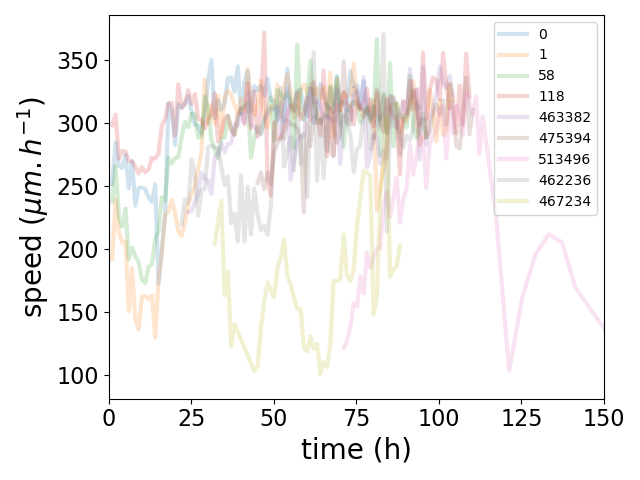

In [206]:
fig,ax = plt.subplots()
for end in select_movements['end'].unique():
    select = select_movements.loc[select_movements['end']==end]
    select =select.sort_values('time_since_begin_h')
    # select['speed_roll'] =select.rolling(2).mean()['speed']
    select = filtering(select)
    ax.plot(select['time_since_begin_h']/(3600*1000),select['speed_smooth'],alpha = 0.2,label = end)
ax.legend()
ax.set_xlim(0,150)
ax.set_xlabel('time (h)')
ax.set_ylabel('speed ($\mu m . h^{-1}$)')
plt.tight_layout()

In [223]:
select_movements = select_movements.loc[select_movements['time_since_begin_h']/(3600*1000)<=60]
select_movements = select_movements.loc[select_movements['time_since_begin_h']/(3600*1000)>=30]

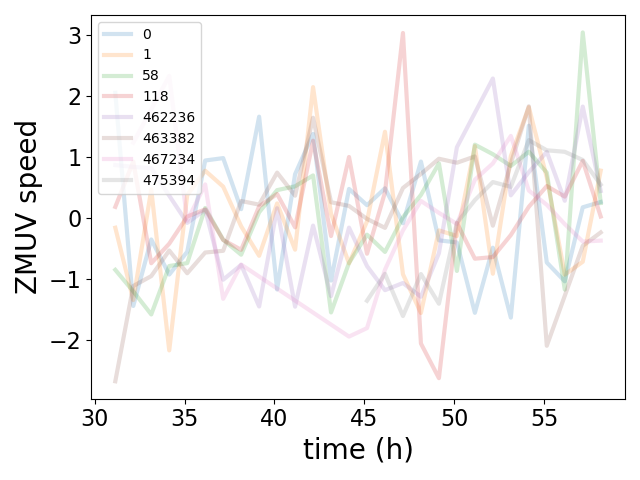

In [224]:
fig,ax = plt.subplots()
for end in select_movements['end'].unique():
    select = select_movements.loc[select_movements['end']==end]
    select =select.sort_values('time_since_begin_h')
    select = filtering(select)
    
    signal = (select['speed_smooth']-np.mean(select['speed_smooth']))/np.std(select['speed_smooth'])
    ax.plot(select['time_since_begin_h']/(3600*1000),signal,alpha = 0.2,label=end)
# ax.set_xlim(0,150)
ax.set_xlabel('time (h)')
ax.set_ylabel('ZMUV speed')
ax.legend()
plt.tight_layout()

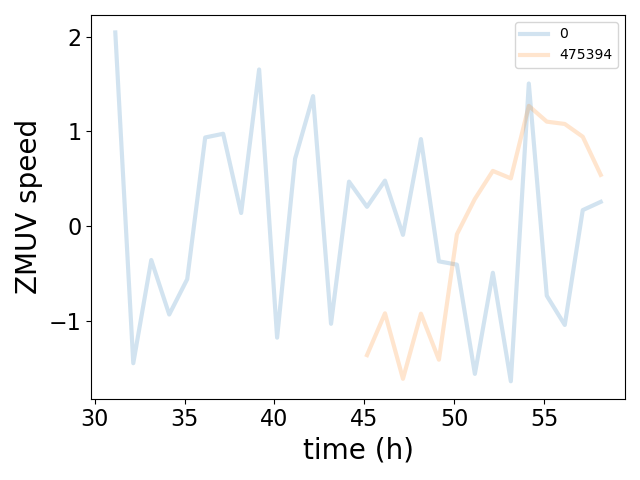

In [230]:
fig,ax = plt.subplots()
for end in [0,475394]:
    select = select_movements.loc[select_movements['end']==end]
    select =select.sort_values('time_since_begin_h')
    select = filtering(select)
    
    signal = (select['speed_smooth']-np.mean(select['speed_smooth']))/np.std(select['speed_smooth'])
    ax.plot(select['time_since_begin_h']/(3600*1000),signal,alpha = 0.2,label=end)
# ax.set_xlim(0,150)
ax.set_xlabel('time (h)')
ax.set_ylabel('ZMUV speed')
ax.legend()
plt.tight_layout()

In [226]:
select0['pos_x'].iloc[0]//5,select0['pos_y'].iloc[0]//5

(2784, 3173)

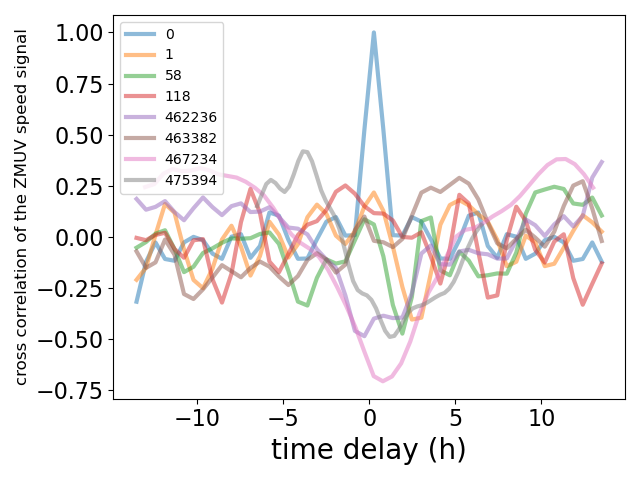

In [227]:
hypha0 = 0
select0 = select_movements.loc[select_movements['end']==hypha0]
select0 = filtering(select0)

ts0 = select0['time_since_begin_h']
cross_correlations = []
fig,ax = plt.subplots()
for end in select_movements['end'].unique():
    select = select_movements.loc[select_movements['end']==end]
    select = select.loc[select['time_since_begin_h'].isin(ts0)]
    ts = select['time_since_begin_h']
    select = filtering(select)
    select2 = select0.loc[select0['time_since_begin_h'].isin(select['time_since_begin_h'])]
    signal0 = ((select2['speed_smooth']-np.mean(select2['speed_smooth']))/np.std(select2['speed_smooth'])).iloc[1:-1]
   
    
    signal = ((select['speed_smooth']-np.mean(select['speed_smooth']))/np.std(select['speed_smooth'])).iloc[1:-1]
    ts = select2['time_since_begin_h'].iloc[1:-1]
    
    if len(signal)>2:
        f0 = interp1d(select2['time_since_begin_h'].iloc[1:-1], signal0)
        f = interp1d(select['time_since_begin_h'].iloc[1:-1], signal)
        lenx = 50
        x = np.linspace(np.min(ts),np.max(ts),lenx)
        resampled = pd.DataFrame({'time':x,'speed':f(x)})
        resampled0 = pd.DataFrame({'time':x,'speed':f0(x)})
        resampled['speed'] = (resampled['speed']-np.mean(resampled['speed']))/np.std(resampled['speed'])
        resampled0['speed'] = (resampled0['speed']-np.mean(resampled0['speed']))/np.std(resampled0['speed'])
        cross_correlation = scipy.signal.correlate(resampled['speed'],resampled0['speed'],'same')/lenx
        ax.plot(((x-np.mean(x))/(3600*1000)),cross_correlation,label =end,alpha = 0.5)
        if end!=hypha0:
            cross_correlations.append(cross_correlation)
    # ax.plot(resampled['time'],resampled['speed'])
    # ax.plot(cross_correlation)
ax.set_xlabel('time delay (h)')
ax.set_ylabel('cross correlation of the ZMUV speed signal',size=12)
ax.legend()
plt.tight_layout()

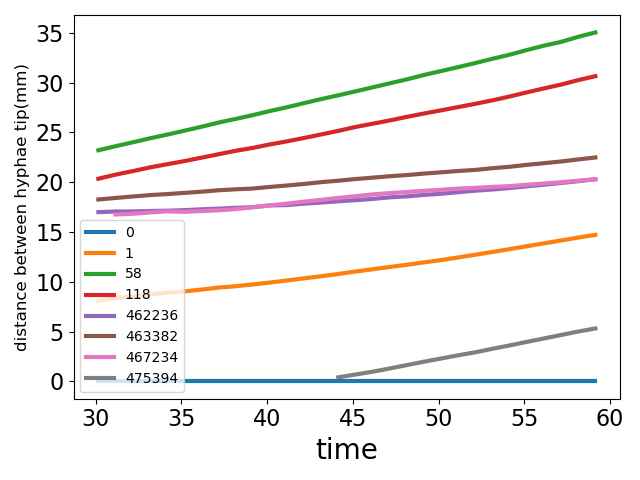

In [228]:
fig,ax = plt.subplots()

select0 = select_movements.loc[select_movements['end']==hypha0]
select0 =select0.sort_values('time_since_begin_h')
ts0 = select0['time_since_begin_h']

select0 =select0.set_index('time_since_begin_h')

for end in select_movements['end'].unique():
    select = select_movements.loc[select_movements['end']==end]
    select = select.loc[select['time_since_begin_h'].isin(ts0)]
    select =select.sort_values('time_since_begin_h')
    select =select.set_index('time_since_begin_h')
    select2 = select0.loc[select0.index.isin(select.index)]
    ax.plot(select.index/(3600*1000),np.sqrt((select['pos_x']-select2['pos_x'])**2+(select['pos_y']-select2['pos_y'])**2)*1.725/1000,label=end)
ax.set_xlabel('time')
ax.set_ylabel('distance between hyphae tip(mm)',size=12)
ax.legend()
plt.tight_layout()

In [ ]:
fig,ax = plt.subplots()
select = select_movements.loc[select_movements['end']==39]
select =select.sort_values('time_since_begin_h')
signal = (select['speed']-np.mean(select['speed']))/np.std(select['speed'])
ax.plot(select['time_since_begin_h']/(3600*1000),signal,alpha = 0.2)
select = select_movements.loc[select_movements['end']==43]
select =select.sort_values('time_since_begin_h')
signal = (select['speed']-np.mean(select['speed']))/np.std(select['speed'])
ax.plot(select['time_since_begin_h']/(3600*1000),signal,alpha = 0.2)
select = select_movements.loc[select_movements['end']==21099]
select =select.sort_values('time_since_begin_h')
signal = (select['speed']-np.mean(select['speed']))/np.std(select['speed'])
ax.plot(select['time_since_begin_h']/(3600*1000),signal,alpha = 0.2)
ax.set_xlim(0,100)

In [ ]:
fig,ax = plt.subplots()
select = select_movements.loc[select_movements['end']==39]
select =select.sort_values('time_since_begin_h')
ax.plot(select['time_since_begin_h']/(3600*1000),select['speed'],alpha = 0.2)
select = select_movements.loc[select_movements['end']==43]
select =select.sort_values('time_since_begin_h')
ax.plot(select['time_since_begin_h']/(3600*1000),select['speed'],alpha = 0.2)
select = select_movements.loc[select_movements['end']==36729]
select =select.sort_values('time_since_begin_h')
ax.plot(select['time_since_begin_h']/(3600*1000),select['speed'],alpha = 0.2)
ax.set_xlim(0,100)

In [ ]:
fig,ax = plt.subplots()
select =select_movements.sort_values('time_since_begin_h')
data = select.groupby('time_since_begin_h')['speed'].mean()
ax.plot(data.index/(3600*1000),data)
ax.set_xlim(0,100)

In [ ]:
xt,yt = data.index/(3600*1000),data
f = interp1d(xt, yt)
frequ = 1
deb = np.min(xt)
end = np.max(xt)
x = np.linspace(deb,end,int((end-deb)*frequ)+1)
resampled = pd.DataFrame({'time':x,'speed':f(x)})

In [ ]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]
y = resampled['speed'][:100]-np.mean(resampled['speed'][:100])
fig, ax = plt.subplots()
autoc = autocorr(y)
autoc = autoc/autoc.max()
lags = np.linspace(0.0, len(autoc), len(autoc), endpoint=False)
ax.plot(lags,autoc, label = 'savgol filter')
ax.set_xlabel('lag (s)')

In [ ]:
y

In [ ]:
import scipy as sp
frequ = 24
signal = y.values
signal_ZMUV = (signal-np.mean(signal))/np.std(signal)
s = signal_ZMUV
autoc = autocorr(s)
autoc = autoc/autoc.max()
speed_fft = sp.fftpack.fft(s)
speed_psd = np.abs(speed_fft) ** 2
fftfreq = sp.fftpack.fftfreq(len(speed_psd))
i = fftfreq > 0
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(frequ*fftfreq[i], speed_psd[i])
ax.set_xlabel('Frequency (s-1)')
ax.set_ylabel('PSD')

In [ ]:
fig, ax = plt.subplots()
ax.plot(signal_ZMUV)